In [1]:
#This code receives data about the performance of algorithms with several instances of a problem 
#and makes a portfolio solver, based on the 2 best solvers (Gurobi and RoundingSAT) (2sbs)
#For each timestep, each solver runs for 1/2 of that time. The portfolio solver outputs the best solution from the 2 solvers 

#INPUT
#2 necessary parameters are received:
# -The path of the data file.
# -The path where the information will be saved

#Example: 

#Fist line of the data file cointains one string, the time unit to be used.
#Next, one line with the algorithm names, divided by spaces.
#Next, one line with the dataset names divided by spaces.
#After that comes D blocks, with D being the number of datasets. Each one of this blocks starts with a number I,
#the number of instances on the dataset, and then follow I blocks.
#Each one of the I blocks starts with the name of the instance and continues with A lines, A being the number
#of algorithms.
#Each of the A lines has the solutions found by one of the algorithms divided by spaces. The lines must be on 
#the same order as the names of the algorithms. The solutions must be in cronological order. Each solution is
#comprised of 2 integer numbers separated by a colon. The first of this numbers is the time in which the solution
#was found. This time must be in the time unit provided at the begginning of this file. The second number is the
#value of the solution.
#Last line of the file must contain integer numbers divided by spaces. This numbers ara the times of interest for
#the bars graph.

#Example: python3 plot.py data.txt ./graphs/

#s
#CLK LKH CONCORDE EAX MAOS
#TSPLIB TNM
#3
#TSPLIB-1
#1:1 3:3 23:22 56:69 100:98
#1:1 3:5 53:59 98:99
#1:1 4:5 11:38 50:79
#1:1 2:6 32:45 72:68
#1:1 7:23 19:52 24:63
#TSPLIB-2
#1:1 3:3 23:22 56:69 100:98
#1:1 3:5 53:59 98:99
#1:1 4:5 11:38 50:79
#1:1 2:6 32:45 72:68
#1:1 7:23 19:52 24:63
#TSPLIB-3
#1:1 3:3 23:22 56:69 100:98
#1:1 3:5 53:59 98:99
#1:1 4:5 11:38 50:79
#1:1 2:6 32:45 72:68
#1:1 7:23 19:52 24:63
#2
#TNM-1
#1:1 6:4 23:25 43:32 78:72 98:99
#1:1 7:10 15:28 40:34 67:83
#1:1 4:12 17:34 33:42 56:74
#1:1 6:14 15:25 21:30 32:44 40:56
#1:1 8:18 13:35 26:44 53:60
#TNM-2
#1:1 3:3 23:22 56:69 100:98
#1:1 3:5 53:59 98:99
#1:1 4:5 11:38 50:79
#1:1 2:6 32:45 72:68
#1:1 7:23 19:52 24:63
#2 50 100


#OUTPUT

#Portfolio solver

#Matrix graph of Portfolio solver
#This graph shows for each instance, represented in the x axis, and each time, represented in the y axis, which is
#the better performing algorithm of the best 2 (2sbs) from which the portfolio was created. The instances are shown from left
#to right in the same order in which they are received.

#Bars graph
#This graph shows groups of bars. Each group belongs to a solver, and each bar on a group represents how many
#best solutions did, in comparison to the rest of the solver, this solver had before a certain time. The
#times of the bars are the times of interest (timesteps) that must be given at the end of the data file.

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
import numpy as np
import pandas as pd
import sys
import os
import math

main_path = "/global/scratch/users/cpezov/AAPBO/"

#read
matrix_graph = True
bars_graph = True
fsize = 22
if len(sys.argv) < 3:
    print("NOT ENOUGH ARGUMENTS")
    sys.exit()
force = False  
maximization = 1
#data = str(sys.argv[1])
#path = str(sys.argv[2])
data = main_path+"results/processed_data/data_graph-v4.txt" #v2 / v3 / v4
path = main_path+"graph/Dataset-v4/" #v2 / v3 / v4
if len(sys.argv) == 3:
    time_scale = "linear"

with open(data,'r') as text:
    time_unit = text.readline().replace("\n","")
    solvers = text.readline().split() #Solver names
    datasets = text.readline().split() #Dataset names
    instances = [] #Instances names
    N_SOLVERS = len(solvers)
    N_DATASETS = len(datasets)
    N_INSTANCES = [] #Number of instances for each dataset
    N_POINTS = [] #Number of points for each solver for each instance
    results = [] #Contains every point of every instance
    plot_max = [] #Artificial final point of every plot for better visualization
    maxmax = 0 #Maximum artificial final point
    for d in range(N_DATASETS):
        N_INSTANCES.append(int(text.readline()))
        for i in range(N_INSTANCES[d]):
            instances.append(text.readline().replace("\n",""))
            max = 0
            aux = []
            for s in range(N_SOLVERS):
                line = text.readline().split()
                count_points = 0
                for point in line:
                    count_points = count_points + 1
                    point = point.split(':')
                    aux.append([float(point[0]), float(point[1]), s])
                    #aux.append([math.log(float(point[0]),2), float(point[1]), s])
                N_POINTS.append(count_points)  
                if aux[-1][0]>max:
                    max = aux[-1][0]
            results.append(aux)    
            plot_max.append(int(max+max*0.1))
            if maxmax < max:
                maxmax = max  
    bt = text.readline().split()
    bar_times = []
    for b in bt:
        bar_times.append(float(b))
    maxmax = maxmax * 1.1

#Original colors

#v4: 
#No solution(white) - clasp(red) - naps(cyan) - open-wbo1(purple)
#open-wbo4(light green) - gurobi(orange) - ls-pbo(yellow) - roundingSat(blue)

colors = ["red","cyan","magenta","greenyellow","darkorange","yellow","dodgerblue"]

In [2]:
n_sbs=2 #2sbs

new_times=[]
for b in bar_times:
    new_times.append(b/n_sbs)

In [3]:
if not force:
    maximization = 1
    aux = None
    for point in results[0]: #resultados de la primera instancia
        if aux == None:
            aux = point[1]
        elif aux < point[1]:
            break
        elif aux > point[1]:
            maximization = -1
            break

In [4]:
starts = []
middles = []
start = 0
starts.append(start)
for i in N_INSTANCES:
    prev_start = start
    start += i
    starts.append(start)
    middles.append(prev_start+((start-prev_start)/2)-0.5)

In [5]:
res_solvers = np.full((N_SOLVERS, starts[-1], 500),np.nan) #for each instance, each new_time, we save the value of the result for each solver
#if a solver has no solution yet, nan is stored

for i in range(starts[-1]):
    for t_count in range(len(new_times)):
        t=new_times[t_count]
        for point in results[i]: #itera por todos los resultados (con sus respectivos tiempos, valor y solver)
            if (point[0]<t or math.isclose(point[0],t)): #está dentro del tiempo new_time (menor o igual)
                solution=point[1]
                s=point[2]
                res_solvers[s][i][t_count]=solution

In [6]:
#then, we analyze the array res_solvers, saving the number of the best solver, or "No solution" if all of them are nan
#(use original identification 0:No solution - 5:gurobi - 7:roundingSat)

solv_n=[5,7] #2sbs : 5:gurobi - 7:roundingSat

portfolio = np.zeros((starts[-1], 500))
portfolio_draw = np.zeros((starts[-1], 500))

for i in range(starts[-1]):
    for ts in range(len(new_times)):
        best=None
        solver=0
        solver_draw=0
        for i_s in range(n_sbs):
            sol=solv_n[i_s]
            solution=res_solvers[sol-1][i][ts] #sol-1: en results, estan enumerados sin considerar el 0:NoSol
            if(np.isnan(solution)):
                continue
            if(best==None):
                best=solution
                solver=sol
                solver_draw=i_s+1
            if(best*maximization < solution*maximization): #la solución es mejor
                best=solution
                solver=sol
                solver_draw=i_s+1
        portfolio[i][ts]=solver
        portfolio_draw[i][ts]=solver_draw

In [7]:
portfolio

array([[7., 7., 7., ..., 5., 5., 5.],
       [7., 7., 7., ..., 5., 5., 5.],
       [5., 7., 7., ..., 5., 5., 5.],
       ...,
       [7., 7., 7., ..., 5., 5., 5.],
       [7., 7., 7., ..., 5., 5., 5.],
       [7., 7., 7., ..., 5., 5., 5.]])

In [9]:
#save portfolio
res_path=main_path+"models/v4/portfolio_solver-2sbs/results/"
f = open(res_path+"portfolio_solver-2sbs.txt", "w")
np.savetxt(f,portfolio.reshape(portfolio.shape[0], -1), delimiter=" ", fmt="%s")
f.close()

In [10]:
a=[solvers[i-1] for i in solv_n]
a

['Gurobi', 'RoundingSAT']

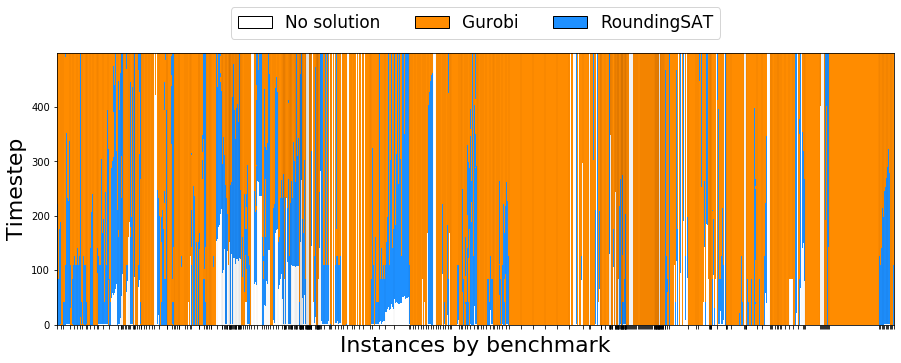

In [11]:
#portfolio plot
labels = [solvers[i-1] for i in solv_n]
labels.insert(0,'No solution')

#Portfolio colors
#No solution(white) - gurobi(orange) - roundingSat(blue) #2sbs
colors = ["white","darkorange","dodgerblue"] #2sbs

co = matplotlib.colors.ListedColormap(colors, N=len(labels))

fig = plt.figure(figsize=(15,5))
plt.imshow(portfolio_draw.T, interpolation='nearest', cmap=co, aspect='auto', origin='lower')
for xc in starts[1:-1]:
    plt.axvline(x=xc-0.5, color="black", alpha=1, lw=0.05)
plt.xticks(ticks=starts, labels=[]) #marca en separacion de benchmarks
#plt.xticks(middles, datasets, rotation=90, fontsize=2) #marca con benchmark names
plt.legend(handles=[mpatches.Patch(facecolor=i, label=j, edgecolor="black") for i,j in zip(colors, labels)], bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=5, fontsize=fsize-5)
plt.xlabel("Instances by benchmark", fontsize=fsize)
plt.ylabel("Timestep", fontsize=fsize)
fig = plt.gcf()
fig.savefig(path + "portfolio-2sbs_385.pdf", bbox_inches = 'tight',dpi=300)
plt.show()

In [12]:
#dividir en benchmarks de carpetas originales

# 118 carpetas originales (+1 que indica el inicio)
real_benchs=[0,16,24,25,33,39,40,49,50,51,52,61,65,77,89,93,96,97,101,104,106,117,125,143,166,168]
real_benchs.extend(range(169,188+1))
real_benchs.extend([195,197])
real_benchs.extend(range(198,207+1))
real_benchs.extend([213,219,225,230,231,232,233,234,239,240,249,272,273,298,299,304,305,310])
real_benchs.extend(range(311,314+1))
real_benchs.extend([322])
real_benchs.extend(range(323,329+1))
real_benchs.extend([334])
real_benchs.extend(range(335,340+1))
real_benchs.extend([349,351,352,354])
real_benchs.extend(range(355,360+1))
real_benchs.extend([362,363,373])
real_benchs.extend(range(374,383+1))
real_benchs.extend([385])

print(len(real_benchs))

starts_og = []
for ind in real_benchs:
    act_ind=ind
    # Considerar que hay carpetas que se eliminaron entre medio
    if(ind>34 and ind<126):
        act_ind=ind-1
    elif(ind>126 and ind<317):
        act_ind=ind-3
    elif(ind>317 and ind<330):
        act_ind=ind-4
    elif(ind>330 and ind<332):
        act_ind=ind-5
    elif(ind>332 and ind<342):
        act_ind=ind-6
    elif(ind>342 and ind<364):
        act_ind=ind-7
    elif(ind>364 and ind<=385):
        act_ind=ind-8
    starts_og.append(starts[act_ind])

len(starts_og)

119


119

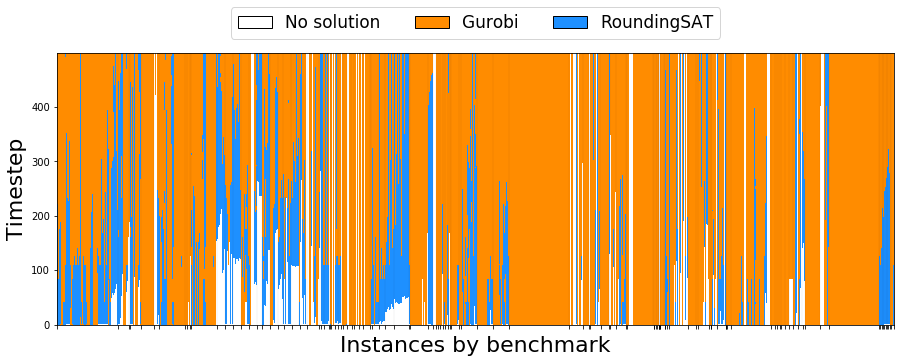

In [13]:
#portfolio plot con carpetas originales

labels = [solvers[i-1] for i in solv_n]
labels.insert(0,'No solution')

#Portfolio colors
#No solution(white) - gurobi(orange) - roundingSat(blue) #2sbs
colors = ["white","darkorange","dodgerblue"] #2sbs

co = matplotlib.colors.ListedColormap(colors, N=len(labels))

fig = plt.figure(figsize=(15,5))
plt.imshow(portfolio_draw.T, interpolation='nearest', cmap=co, aspect='auto', origin='lower')
for xc in starts_og[1:-1]:
    plt.axvline(x=xc-0.5, color="black", alpha=1, lw=0.05)
plt.xticks(ticks=starts_og, labels=[]) #marca en separacion de benchmarks
#plt.xticks(middles, datasets, rotation=90, fontsize=2) #marca con benchmark names
plt.legend(handles=[mpatches.Patch(facecolor=i, label=j, edgecolor="black") for i,j in zip(colors, labels)], bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=5, fontsize=fsize-5)
plt.xlabel("Instances by benchmark", fontsize=fsize)
plt.ylabel("Timestep", fontsize=fsize)
fig = plt.gcf()  
fig.savefig(path + "portfolio-2sbs.pdf", bbox_inches = 'tight',dpi=300)
plt.show()

## Evaluar y guardar los resultados de test 

In [14]:
#labels
solvers=[]
with open(main_path+"labels-v4.txt") as f:
    lines = f.readlines()
    for l in lines:
        for word in l.split():
            solvers.append(int(word))

len(solvers)/500

3128.0

In [15]:
import random

#agrupar diferentes timesteps de cada instancia en un mismo set
random.seed(9) #same seed to generate same random numbers as other models
portfolio_train=[]
portfolio_test=[]
y_test=[]
for i in range(0,3128): # v4
    r = random.randint(0,2)
    if(r==2):
        portfolio_test.append(portfolio[i])
        for j in range(0,500):
            y_test.append(solvers[500*i+j])
    else:
        portfolio_train.append(portfolio[i])

portfolio_train=np.array(portfolio_train)
portfolio_test=np.array(portfolio_test)
y_test=np.array(y_test)

In [16]:
from sklearn import metrics

y_pred=portfolio_test.flatten()
print("Accuracy",metrics.accuracy_score(y_test, y_pred))

Accuracy 0.6044208566108007


In [17]:
y_pred_np=portfolio_test
f = open(main_path+"models/v4/portfolio_solver-2sbs/results/y_preds.txt", "w")
np.savetxt(f,y_pred_np.reshape(y_pred_np.shape[0],-1),fmt='%s')
f.close()

## OLD

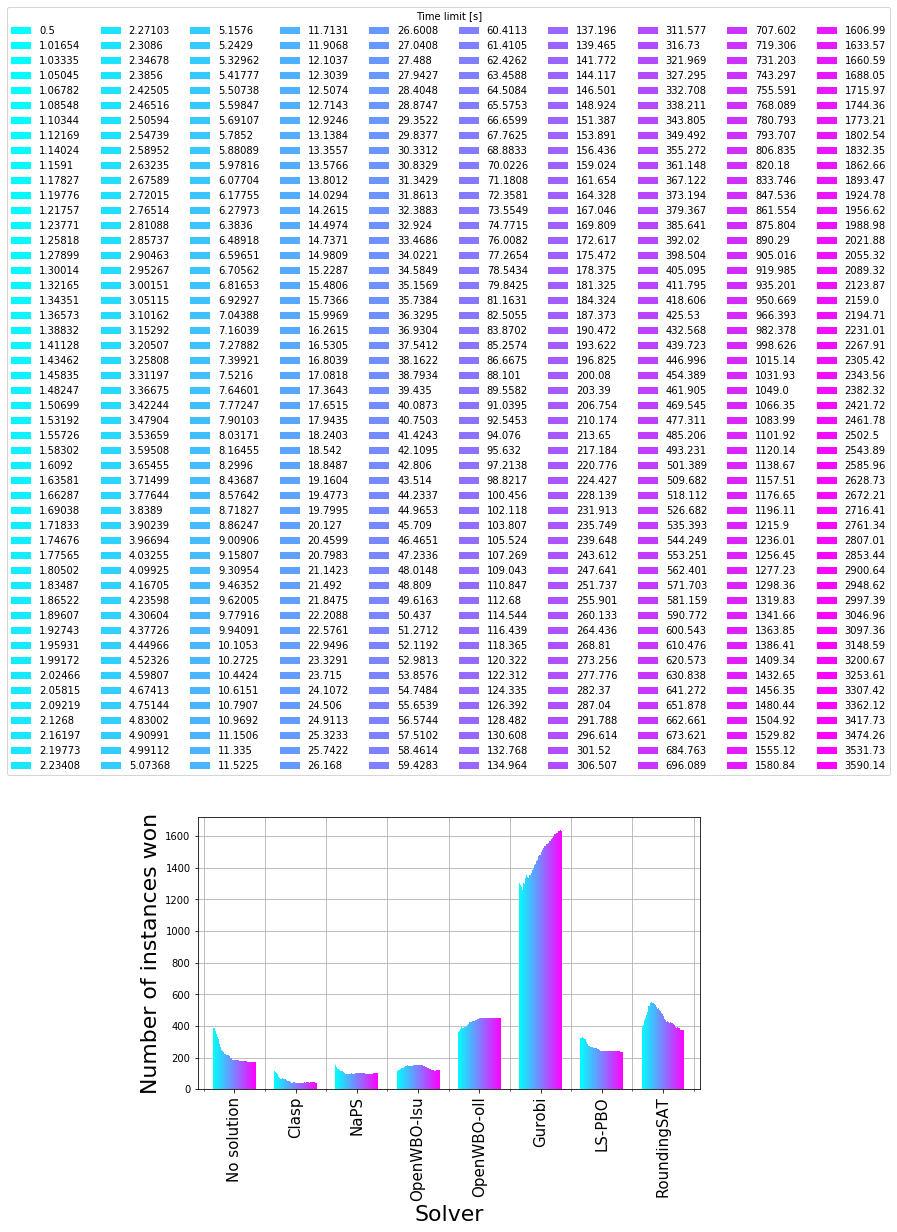

In [8]:
#Bars with "NO SOLUTION" label

if bars_graph:
    valid = True
    for b in bar_times:
        if b < 0:
            print("INVALID TIME VALUES FOR BAR PLOT")
            valid = False
        if b > maxmax - 1:
            b = maxmax - 1  

    if valid:    
        bar_scores = []
        for b in range(500):
            bar_s = [0]*(N_SOLVERS+1)
            for i in range(starts[-1]):
                bar_s[int(matrix[i][b])] = bar_s[int(matrix[i][b])] + 1
            bar_scores.append(bar_s)
    df = pd.DataFrame(bar_scores)
    labels = solvers[:]
    labels.insert(0,'No solution')
    df.columns = labels
    df = df.transpose()
    df.columns = bar_times

    from matplotlib.ticker import AutoMinorLocator
    from matplotlib.ticker import FixedLocator

    colors = matplotlib.cm.get_cmap('cool', len(bar_times))
    plot = df.plot(kind="bar", stacked=False, zorder=2, figsize = (9,5), width=0.7, cmap=colors)
    fig = plot.get_figure()

    plt.xlabel("Solver", fontsize=fsize)
    plt.ylabel("Number of instances won", fontsize=fsize)
    plt.xticks(rotation=90, fontsize=fsize-7)

    minor_locator1 = AutoMinorLocator(2)
    plt.gca().xaxis.set_minor_locator(minor_locator1)

    plt.grid(which='minor')
    plt.grid(axis="y")
    plt.legend(title="Time limit [" + time_unit + "]", bbox_to_anchor=(0.5, 4), loc='upper center', ncol=10)
    fig = plt.gcf()  
    fig.savefig(path + "bars_log.pdf", bbox_inches = 'tight',dpi=300)
    plt.show()